# Analysis

## 1. Loading Data and Modules

In [7]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import tensorflow as tf

path_parent = os.path.dirname(os.getcwd())

if os.getcwd()[-8:] != 'FYP-Code':
    os.chdir(path_parent)

print(os.getcwd())

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code


In [8]:
from helper.synthesis import generate_data

In [9]:
# generate_data()

In [10]:
from analysis.pointwise.utils import load_data, init_model
from analysis.pointwise.train import train_model

params_range_train, params_range_test, price_train, price_test = load_data()

## 2. Training Model

In [11]:
model = init_model()

Model: "dense_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  224       
                                                                 
 dense_5 (Dense)             multiple                  1056      
                                                                 
 batch_normalization_1 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             multiple                  1056      
                                                                 
 dense_7 (Dense)             multiple                  33        
                                                                 
Total params: 2,497
Trainable params: 2,433
Non-trainable params: 64
__________________________________________________

2023-03-10 15:28:36,550 | INFO: | train.py | train_model | 120: Beginning training for model dense with vasicek


Training...: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

2023-03-10 15:28:38,813 | INFO: | train.py | train_model | 169: Saved weights to file: weights/pointwise/weights.h5


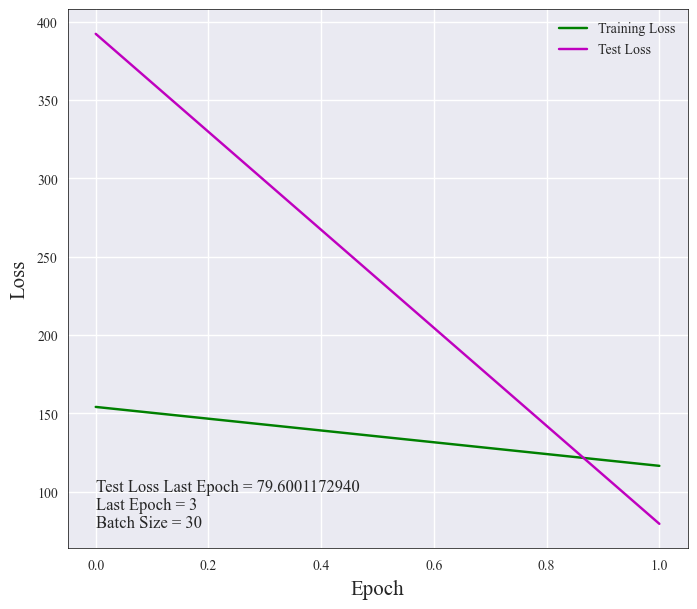

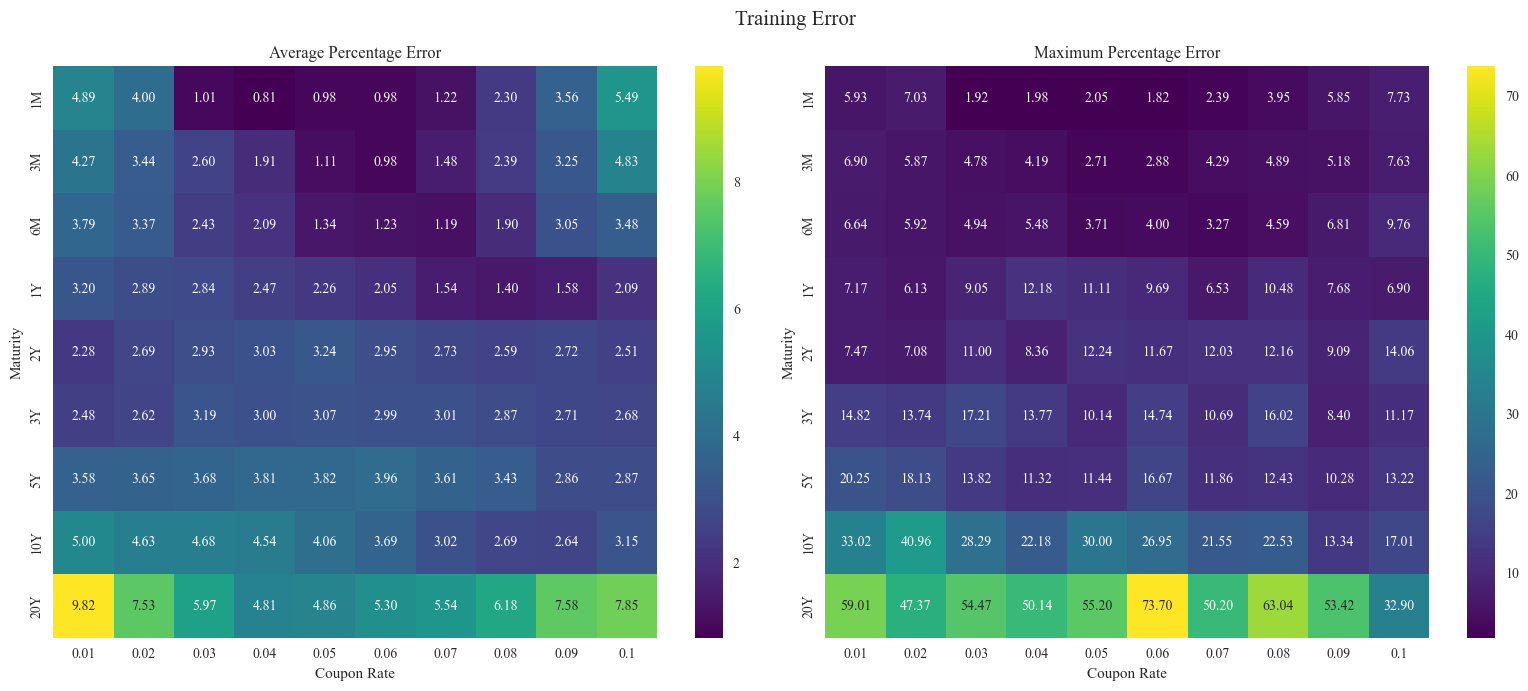

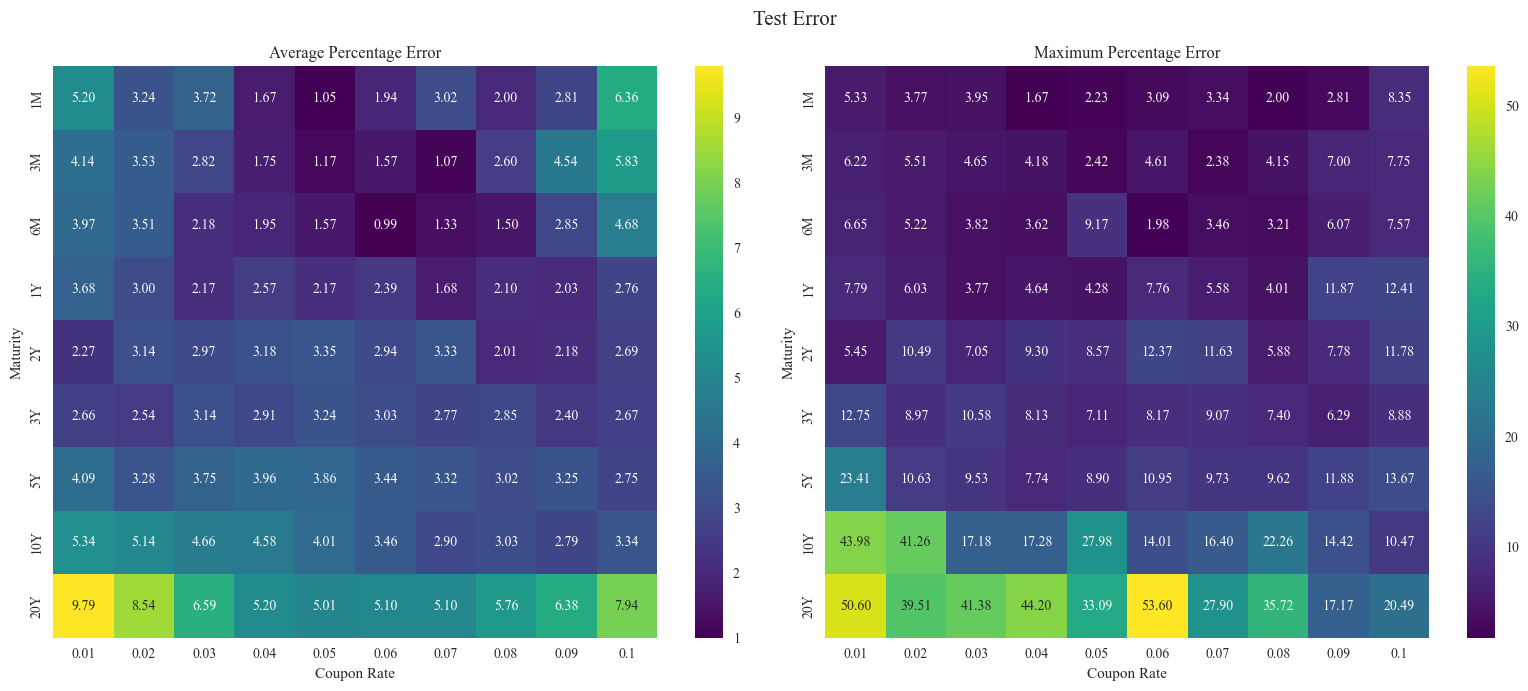

In [13]:
train_model(model = model, epochs = 2, plot = True);

## Synthetic Calibration

Model: "dense_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            multiple                  224       
                                                                 
 dense_13 (Dense)            multiple                  1056      
                                                                 
 batch_normalization_3 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            multiple                  1056      
                                                                 
 dense_15 (Dense)            multiple                  33        
                                                                 
Total params: 2,497
Trainable params: 2,433
Non-trainable params: 64
__________________________________________________

Calibrating...: 100%|██████████| 100/100 [00:03<00:00, 33.13it/s]

2023-03-10 15:29:43,651 | INFO: | calibrate_synthetic.py | calibrate_synthetic | 156: Calibration complete! change in parameters: 0.2647673896180458
2023-03-10 15:29:43,653 | INFO: | calibrate_synthetic.py | calibrate_synthetic | 160: Saved parameters to file: data/pointwise/calibrated_parameters.dat


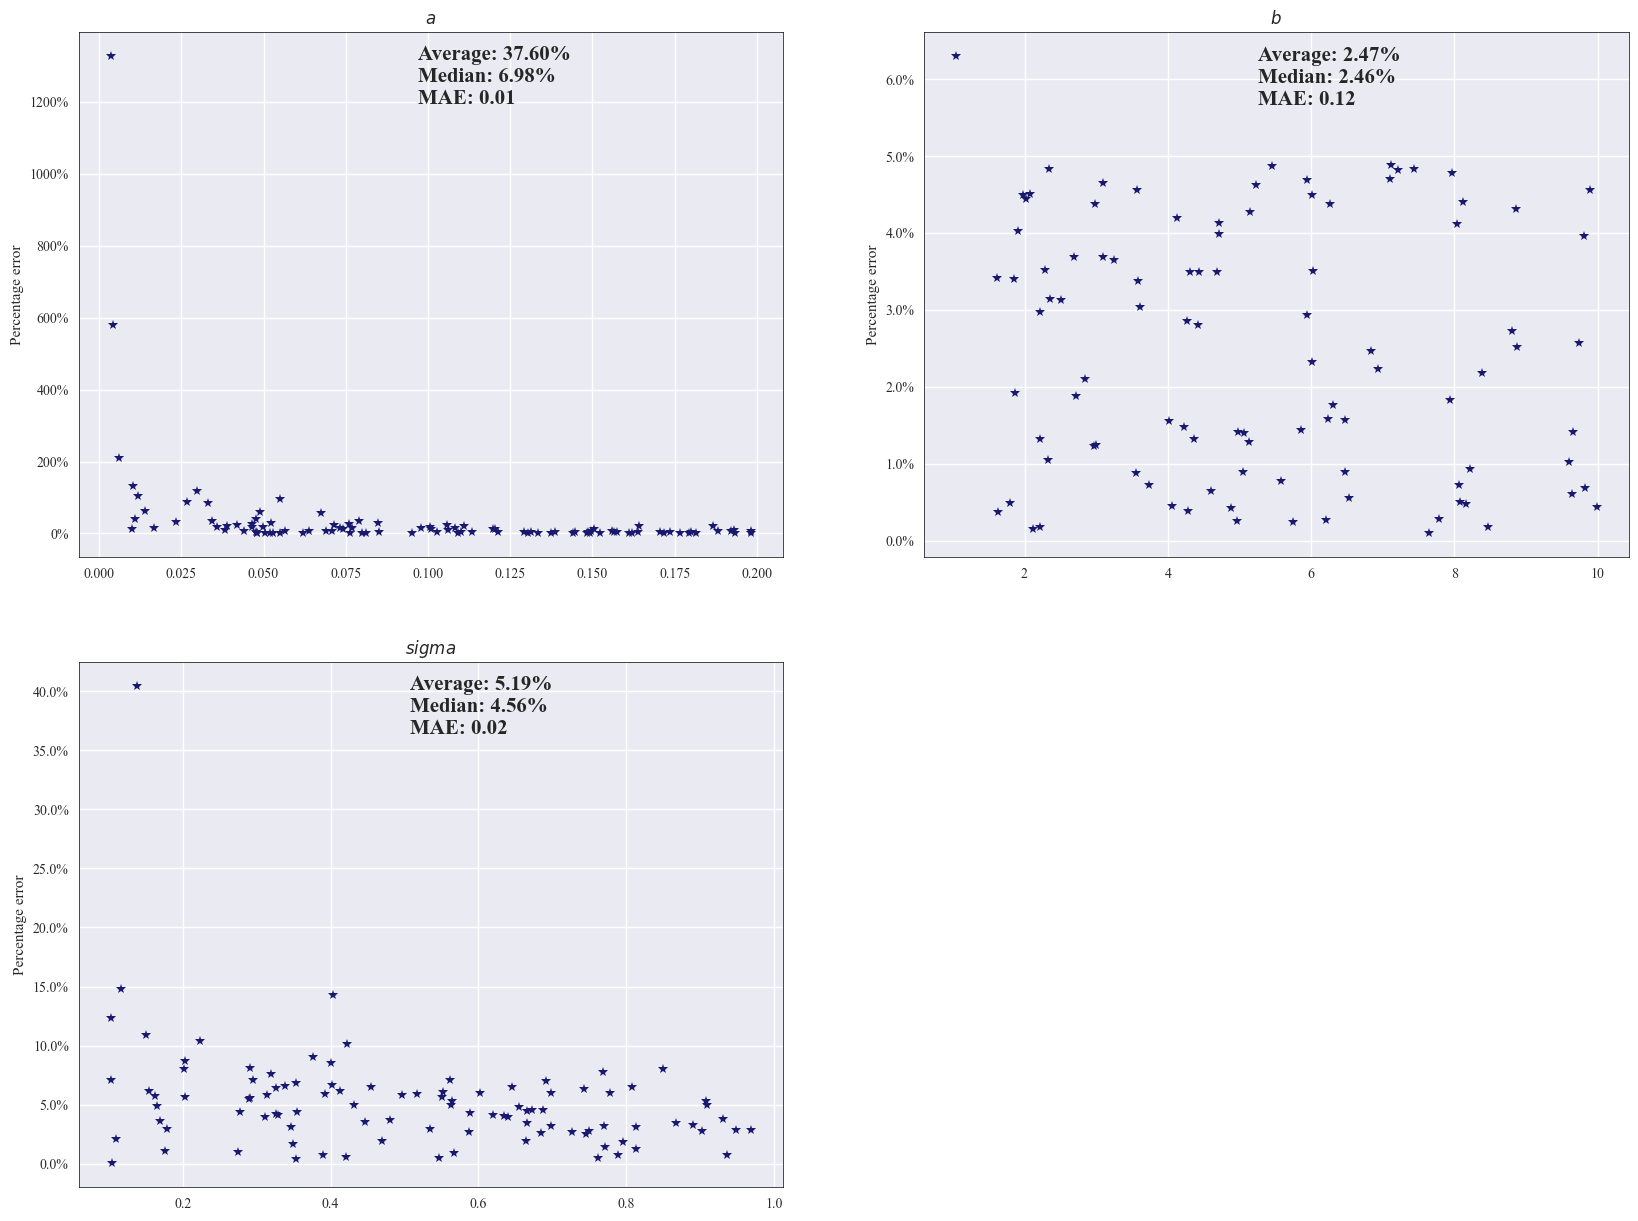

In [15]:
from analysis.pointwise.calibrate_synthetic import calibrate_synthetic
from analysis.pointwise.utils import load_weights, init_model

model = init_model()

load_weights(model)

calibrate_synthetic(
        model, calibration_size = 100, epochs = 20, model_type = 'dense', parameterization =
        'vasicek',
        verbose_length = 10
        )

## 3. Market Calibration

In [16]:
def bond_price(par, T, ytm, coup, freq = 2):
    freq = float(freq)
    periods = T * freq
    coupon = coup * par / freq
    dt = [(i + 1) / freq for i in range(int(periods))]
    price = sum([coupon / (1 + ytm / freq) ** (freq * t) for t in dt]) + par / (1 + ytm / freq) ** (freq * T)
    return price

bond_price(par = 100, T = 1, ytm = 0.02, coup = 0.04, freq = 1)

101.96078431372548

In [17]:
from analysis.pointwise.calibrate_market import calibrate_to_market_data
from analysis.pointwise.utils import load_weights, init_model

model = init_model()

load_weights(model)

Model: "dense_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            multiple                  224       
                                                                 
 dense_17 (Dense)            multiple                  1056      
                                                                 
 batch_normalization_4 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 dense_18 (Dense)            multiple                  1056      
                                                                 
 dense_19 (Dense)            multiple                  33        
                                                                 
Total params: 2,497
Trainable params: 2,433
Non-trainable params: 64
__________________________________________________

In [ ]:
from hyperparameters import coupons, maturities_label

for maturity in maturities_label:

    df = pd.read_csv(f'market_data/{maturity}_cleaned.csv')

    c = coupons[maturity]
    b = 5
    a = 5
    sigma = 0.3
    rho = 0
    eta = 0.3
    x = 0.01
    y = 0.01
    phi = df.Price[0]

    initial_parameters = [c, phi, x, y, a, b, sigma, eta, rho]

    calibrate_to_market_data(
            model = model,
            market_data = df['Bond Price'],
            time_to_expiry = df['Time to Expiry'],
            initial_parameters = np.array(initial_parameters, dtype = np.float64),
            epochs = 200,
            model_type = 'dense',
            parameterization = 'two_factor',
            verbose_length = 100,
            maturity = maturity,
                    )

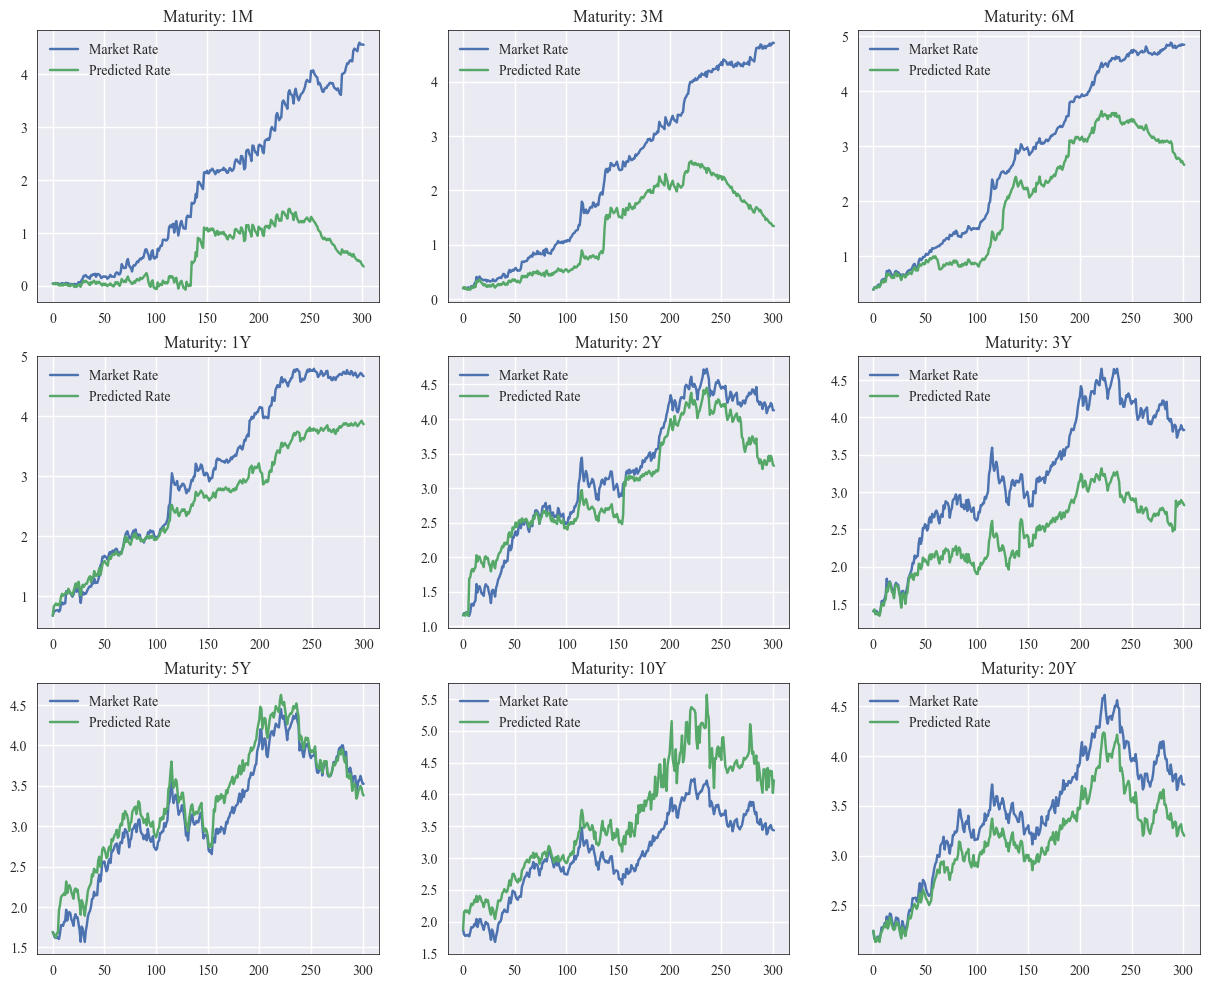

In [62]:

import matplotlib.pyplot as plt
from hyperparameters import coupons, maturities_label


fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 12))

k = -1
j = 0

for i, maturity in enumerate(maturities_label):

    if i % 3 == 0:
        k += 1
        j = 0

    df = pd.read_csv(f'market_data/{maturity}_cleaned.csv')
    calib = pd.read_table(f"data/pointwise/market_calibrated_parameters_{maturity}.dat", sep = " ", header = None)

    # (100 * calib.loc[:, 2]).plot(ax = ax, label = 'Predicted Rate');
    ax[k][j].plot(df.Price, label = 'Market Rate');
    (100 * calib.loc[:, 2]).plot(ax = ax[k][j], label = 'Predicted Rate');
    # ax[k][j].plot(100*calib.loc[:, 2], label = 'Market Rate');
    ax[k][j].set_title(f'Maturity: {maturity}')
    # ax[i].set_xlim((50, 300))
    # ax[i].set_ylim((0, 100))

    ax[k][j].legend()
    j += 1

## 4. Sensitivity Analysis

In [ ]:
calib

In [ ]:
import numpy as np
from tqdm import tqdm
import random
from helper.utils import BondPricing

a_list = np.linspace(0, 1, 500)
b_list = np.linspace(1, 2, 500)
sigma_list = np.linspace(0.001, 0.1, 500)
r_list = np.linspace(0.001, 0.06, 500)
maturities = np.linspace(0.1, 30, 500)

a = 0.02638
b = 2  #(0.053703)
sigma = 0.35384  #(0.00099592)
r = 0.02

random.shuffle(maturities)
random.shuffle(r_list)

sigma_result = []
for sigma_hat, tau in tqdm(zip(sigma_list, maturities)):

    bp = BondPricing(parameters = [a, b, sigma_hat, r])
    price = bp(tau)
    sigma_result.append(price)

a_result = []
for a_hat, tau in tqdm(zip(a_list, maturities)):

    bp = BondPricing(parameters = [a_hat, b, sigma, r])
    price = bp(tau)
    a_result.append(price)

b_result = []
for b_hat, tau in tqdm(zip(b_list, maturities)):

    bp = BondPricing(parameters = [a, b_hat, sigma, r])
    price = bp(tau)
    b_result.append(price)

r_result = []
for r_hat, tau in tqdm(zip(r_list, maturities)):

    bp = BondPricing(parameters = [a, b, sigma, r_hat])
    price = bp(tau)
    r_result.append(price)

a_b_result = []
for a_hat, b_hat in tqdm(zip(a_list, b_list)):

    bp = BondPricing(parameters = [a_hat, b_hat, sigma, r])
    price = bp(1)
    a_b_result.append(price)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = Axes3D(fig)
ax = plt.axes(projection = '3d')
ax.plot_trisurf(
        a_list, maturities, a_result,
        cmap = 'viridis', edgecolor = 'none'
        );

ax.set_title('Sensitivity Analysis: a');

ax.set_xlabel('a')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price');

ax.view_init(30, 50, 0)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = Axes3D(fig)
ax = plt.axes(projection = '3d')
ax.plot_trisurf(
        b_list, maturities, b_result,
        cmap = 'viridis', edgecolor = 'none'
        );

ax.set_title('Sensitivity Analysis: b');

ax.set_xlabel('b')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price');

ax.view_init(30, 70, 0)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = Axes3D(fig)
ax = plt.axes(projection = '3d')
ax.plot_trisurf(
        sigma_list, maturities, sigma_result,
        cmap = 'viridis', edgecolor = 'none'
        );

ax.set_title('Sensitivity Analysis: sigma');

ax.set_xlabel('sigma')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price');

ax.view_init(30, 170, 0)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

fig = plt.figure()
ax = Axes3D(fig)
ax = plt.axes(projection = '3d')
ax.plot_trisurf(
        r_list, maturities, r_result,
        cmap = 'viridis', edgecolor = 'none'
        );

ax.set_title('Sensitivity Analysis: $r$');

ax.set_xlabel('r')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price');

ax.view_init(30, 0, 0)